# Regridding curvilinear data using python
__Jonah Shaw, 2021/02/09__

I am going to try and write a flexible python function that functions like np.interp_like, but works for curvilinear grids and handles longitude mismatches.

### Add paths to run locally or off Cheyenne or Casper 

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, xe,
    Path
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)
    
elif 'casper' in host: # Check if running on NIRD through the Jupyter Hub
    print('Running through CISL Casper')
    obs_dir = '/glade/u/home/jonahshaw/w/obs/'
#     model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
    os.chdir(obs_dir)
    
elif 'r6i6' in host: # Check if running on NIRD through the Jupyter Hub
    print('Running through CISL Cheyenne')
    obs_dir = '/glade/u/home/jonahshaw/w/obs/'
#     model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
    os.chdir(obs_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = '/glade/u/home/jonahshaw/figures/'
obs_dir = '/glade/u/home/jonahshaw/w/obs/'
model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
# case_dir = '/glade/p/cesm/pcwg/jenkay/COSP/cesm21/' 

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(model_dir) #and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through CISL Casper
Can access all directory paths: True


## Functions for xESMF interpolation:

### Main function
Should function like xr.interp_like. For repeated use, an xESMF regridder can be passed so weights are not recalculated for many separate interpolations.

In [3]:
def interp_like2D(ds_in, target=None, method='bilinear',verbose=False,regridder=None):
    '''
    Wrapper function for xESMF regridder object.
    Takes an xarray dataarray or dataset and interpolates to
    the lat-lon grid of the target for all variables with lat-lon vars.
    Returns interpolated array and regridder object for repeated use.
    Either target or regridder have to be supplied in the function call.
    '''
    
    # Get correct horizontal coordinate names (differs between models, obs)
    ds_lat,ds_lon = get_horiz_coords(ds_in, verbose=verbose)
    
    # Remove non-horizontal variables from the input dataset (returned as drops):
    ds_clean,drops = get_horiz_vars(ds_in, verbose=verbose)
    
    # Rotate and wrap longitude appropriately:
    ds_clean.coords[ds_lon] = ds_clean.coords[ds_lon] % 360
    ds_clean = ds_clean.sortby(ds_clean.coords[ds_lon]) # Needed to avoid no data at 180 lon
    ds_clean = ds_clean.astype(dtype='float32',order='C') # Set to 'C-Contiguous' ordering to avoid an error from sortby
    
    # Create target grid and regridder if it wasn't been passed
    if not regridder:
        targ_lat,tar_lon = get_horiz_coords(target, verbose=verbose)
    
        # Create target lat-lon grid from target input
        targ_out = xr.Dataset({targ_lat: ([targ_lat], target[targ_lat].values),
                         tar_lon: ([tar_lon], target[tar_lon].values),}
                             )
        regridder = xe.Regridder(ds_clean, targ_out, method)
    
    # Regrid!
    try:
        ds_out = regridder(ds_clean)
    except:
        print('Regrid failed. Input was: ', ds_clean)
        return None
    
    # Add lat/lon free dropped variables back in (what about just lat or lon?)
    for i in drops:
        ds_out[i] = drops[i]
#         if not any(get_horiz_coords(i, verbose=verbose)):
#             print("I should add %s back in." % i)

    return ds_out,regridder
    

In [4]:
def get_horiz_coords(ds,verbose=False):
    '''
    Helper function for interpolation. Distinguishes between
    netCDF files using lat-lon and latitude-longitude conventions.
    '''
    
    if 'lat' in ds.coords:
        _lat = 'lat'
    elif 'latitude' in ds.coords:
        _lat = 'latitude'
    else:
        if verbose: print('Recognizable latitude coordinate not found.')
        _lat = False
    
    if 'lon' in ds.coords:
        _lon = 'lon'
    elif 'longitude' in ds.coords:
        _lon = 'longitude'
    else:
        if verbose: print('Recognizable longitude coordinate not found.')
        _lon = False
    
    return _lat,_lon
    

In [5]:
def get_horiz_vars(ds_in,verbose=False):
    '''
    Helper function for interp_like2D. 
    Removes non-lat/lon variables that would cause the interpolation to fail.
    Transposes variables so that any remaining coordinates come before lat/lon?
    ^See documentation of xESMF for explanation.
    '''
    ds = ds_in.copy()
    
    coords = ds.coords # Data coords to check against
    drops = {}
    for i in ds.variables:
        if i not in coords: # Cross-check against coordinates
            _horiz_coords = get_horiz_coords(ds[i])
            if False in _horiz_coords:
                if verbose: print('Will not interpolate "%s", horizontal coordinates not found.' % i)
                drops[i] = raw_goccp[i] # Save variable so it isn't lost to append later.
                ds = ds.drop(i)
            else: # This is where I would transpose if necessary, but that is not yet an issue.
                pass
    #             test_ds[i] = test_ds[i].transpose(...,_horiz_coords[0],_horiz_coords[1])

        else:
            if verbose: print('Excluded "%s" because found in coords: ' % i)
            
    return ds, drops

## These wrapper functions make it easy to call interp_like2D on many files at once.

In [6]:
def interp_files(in_paths,out_paths,target,use_dask=False):
    '''
    This is a wrapper for interp_like2D to process multiple files.
    I am trying to build in parallizability, but dask isn't working for me yet.
    '''
    # Need to figure out how to use dask here.
#     https://docs.dask.org/en/latest/delayed-best-practices.html
    
    # Process the first file to create a regridder.
    target_ds = xr.open_dataset(target)
    regridder = interp_and_save(in_paths[0],out_paths[0],target=target_ds)
    target_ds.close()
    
    results = []
    for _in,_out in zip(in_paths[1:],out_paths[1:]):
        if use_dask:
            _task = dask.delayed(interp_and_save)(_in,_out,regridder=regridder)
            results.append(_task)
        else:
            interp_and_save(_in,_out,regridder=regridder)
            
    if use_dask: dash.compute(*results)
        
#     regridder.close() # ?

In [7]:
def interp_and_save(in_path,out_path, **kwargs):
    '''
    To be called by interp_files().
    Organized this way to work well with Dask.
    '''
    # kwargs will be the target or regridder and potentially the method as well
    
    ds = xr.open_dataset(in_path)
    
    ds_out,regrdr = interp_like2D(ds, **kwargs) 
    
    ds_out.to_netcdf(out_path)
    ds.close()
    
    return regrdr #?

## Demonstrate single file interpolation:
Working with interpolating 2x2 GOCCP data to a 1-deg CESM grid.

In [8]:
%cd /glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/
%ls

/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata
1.25x0.9_from_1x1_python/  1.25x0.9_python_interp/  grid_2x2_L40/
1.25x0.9_interpolation/    grid_1x1xL40/            remapweights.nc


Open raw GOCCP data and 1x1 CESM grid (all variables monthly output).

In [16]:
raw_goccp = xr.open_dataset('grid_2x2_L40/2006/MapLowMidHigh_Phase330m_200606_avg_CFMIP2_sat_3.1.2.nc')
cesm2_09res = xr.open_dataset('%s/cesm21/cesm2p1_B1850_COSP2_PCWG/atm/hist/%s' % (model_dir,'cesm2p1_B1850_COSP2_PCWG.cam.h0.0003-05.nc'))

In [34]:
raw_goccp = xr.open_dataset('grid_2x2_L40/2012/MapLowMidHigh_Phase330m_201210_avg_CFMIP2_sat_3.1.2.nc')
raw_goccp

<xarray.Dataset>
Dimensions:          (cat1: 6, latitude: 90, longitude: 180, time: 1, toplvl: 3)
Coordinates:
  * longitude        (longitude) float32 -179.0 -177.0 -175.0 ... 177.0 179.0
  * latitude         (latitude) float32 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * toplvl           (toplvl) float32 0.0 0.0 0.0
  * time             (time) datetime64[ns] 2012-10-16
Dimensions without coordinates: cat1
Data variables:
    category         (cat1) |S25 ...
    cllcalipso_liq   (time, latitude, longitude) float32 ...
    clmcalipso_liq   (time, latitude, longitude) float32 ...
    clhcalipso_liq   (time, latitude, longitude) float32 ...
    cltcalipso_liq   (time, latitude, longitude) float32 ...
    cllcalipso_ice   (time, latitude, longitude) float32 ...
    clmcalipso_ice   (time, latitude, longitude) float32 ...
    clhcalipso_ice   (time, latitude, longitude) float32 ...
    cltcalipso_ice   (time, latitude, longitude) float32 ...
    cllcalipso_un    (time, cat1, latitude, longitude) float32 ...
    clmcalipso_un    (time, cat1, latitude, longitude) float32 ...
    clhcalipso_un    (time, cat1, latitude, longitude) float32 ...
    cltcalipso_un    (time, cat1, latitude, longitude) float32 ...
    cllcalipso_RPIC  (time, latitude, longitude) float32 ...
    clmcalipso_RPIC  (time, latitude, longitude) float32 ...
    clhcalipso_RPIC  (time, latitude, longitude) float32 ...
    cltcalipso_RPIC  (time, latitude, longitude) float32 ...
Attributes:
    Description:               GOCCP_Map_Low_Mid_High_Phase_file
    Date:                      
    Version:                   Prog_version
    Author:                    Gregory CESANA, Helene CHEPFER, LMD/IPSL
    Scientific_contact:        helene.chepfer@lmd.polytechnique.fr
    Technical_support:         gregory.cesana@lmd.polytechnique.fr
    Creationdate:              20180415
    Website:                   http://climserv.ipsl.polytechnique.fr/cfmip-ob...
    References:                Chepfer et al, 2010, The GCM Oriented CALIPSO ...
    history:                   Thu Apr 26 03:00:39 2018: ncra -O /bdd/CFMIP/C...
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1

In [26]:
raw_goccp

<xarray.Dataset>
Dimensions:          (cat1: 6, latitude: 90, longitude: 180, time: 1, toplvl: 3)
Coordinates:
  * longitude        (longitude) float32 -179.0 -177.0 -175.0 ... 177.0 179.0
  * latitude         (latitude) float32 -89.0 -87.0 -85.0 ... 85.0 87.0 89.0
  * toplvl           (toplvl) float32 0.0 0.0 0.0
  * time             (time) datetime64[ns] 2010-06-15T12:00:00
Dimensions without coordinates: cat1
Data variables:
    category         (cat1) |S25 ...
    cllcalipso_liq   (time, latitude, longitude) float32 ...
    clmcalipso_liq   (time, latitude, longitude) float32 ...
    clhcalipso_liq   (time, latitude, longitude) float32 ...
    cltcalipso_liq   (time, latitude, longitude) float32 ...
    cllcalipso_ice   (time, latitude, longitude) float32 ...
    clmcalipso_ice   (time, latitude, longitude) float32 ...
    clhcalipso_ice   (time, latitude, longitude) float32 ...
    cltcalipso_ice   (time, latitude, longitude) float32 ...
    cllcalipso_un    (time, cat1, latitude, longitude) float32 ...
    clmcalipso_un    (time, cat1, latitude, longitude) float32 ...
    clhcalipso_un    (time, cat1, latitude, longitude) float32 ...
    cltcalipso_un    (time, cat1, latitude, longitude) float32 ...
    cllcalipso_RPIC  (time, latitude, longitude) float32 ...
    clmcalipso_RPIC  (time, latitude, longitude) float32 ...
    clhcalipso_RPIC  (time, latitude, longitude) float32 ...
    cltcalipso_RPIC  (time, latitude, longitude) float32 ...
Attributes:
    Description:               GOCCP_Map_Low_Mid_High_Phase_file
    Date:                      
    Version:                   Prog_version
    Author:                    Gregory CESANA, Helene CHEPFER, LMD/IPSL
    Scientific_contact:        helene.chepfer@lmd.polytechnique.fr
    Technical_support:         gregory.cesana@lmd.polytechnique.fr
    Creationdate:              20190107
    Website:                   http://climserv.ipsl.polytechnique.fr/cfmip-ob...
    References:                Chepfer et al, 2010, The GCM Oriented CALIPSO ...
    history:                   Wed Jan  9 11:53:35 2019: ncra -O /bdd/CFMIP/C...
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1

### Interpolate the GOCCP data

In [10]:
outtest,rgrdr = interp_like2D(raw_goccp,cesm2_09res)

### Lon-lat grid is now 1.25x0.9

In [11]:
outtest

<xarray.Dataset>
Dimensions:          (cat1: 6, lat: 192, lon: 288, time: 1, toplvl: 3)
Coordinates:
  * toplvl           (toplvl) float32 0.0 0.0 0.0
  * time             (time) datetime64[ns] 2006-06-21T18:00:00
  * lon              (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat              (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
Dimensions without coordinates: cat1
Data variables:
    cllcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_liq   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_ice   (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_un    (time, cat1, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cllcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clmcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clhcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cltcalipso_RPIC  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    category         (cat1) |S25 ...
Attributes:
    regrid_method:  bilinear

### Plot shows slightly larger NaN areas than the original

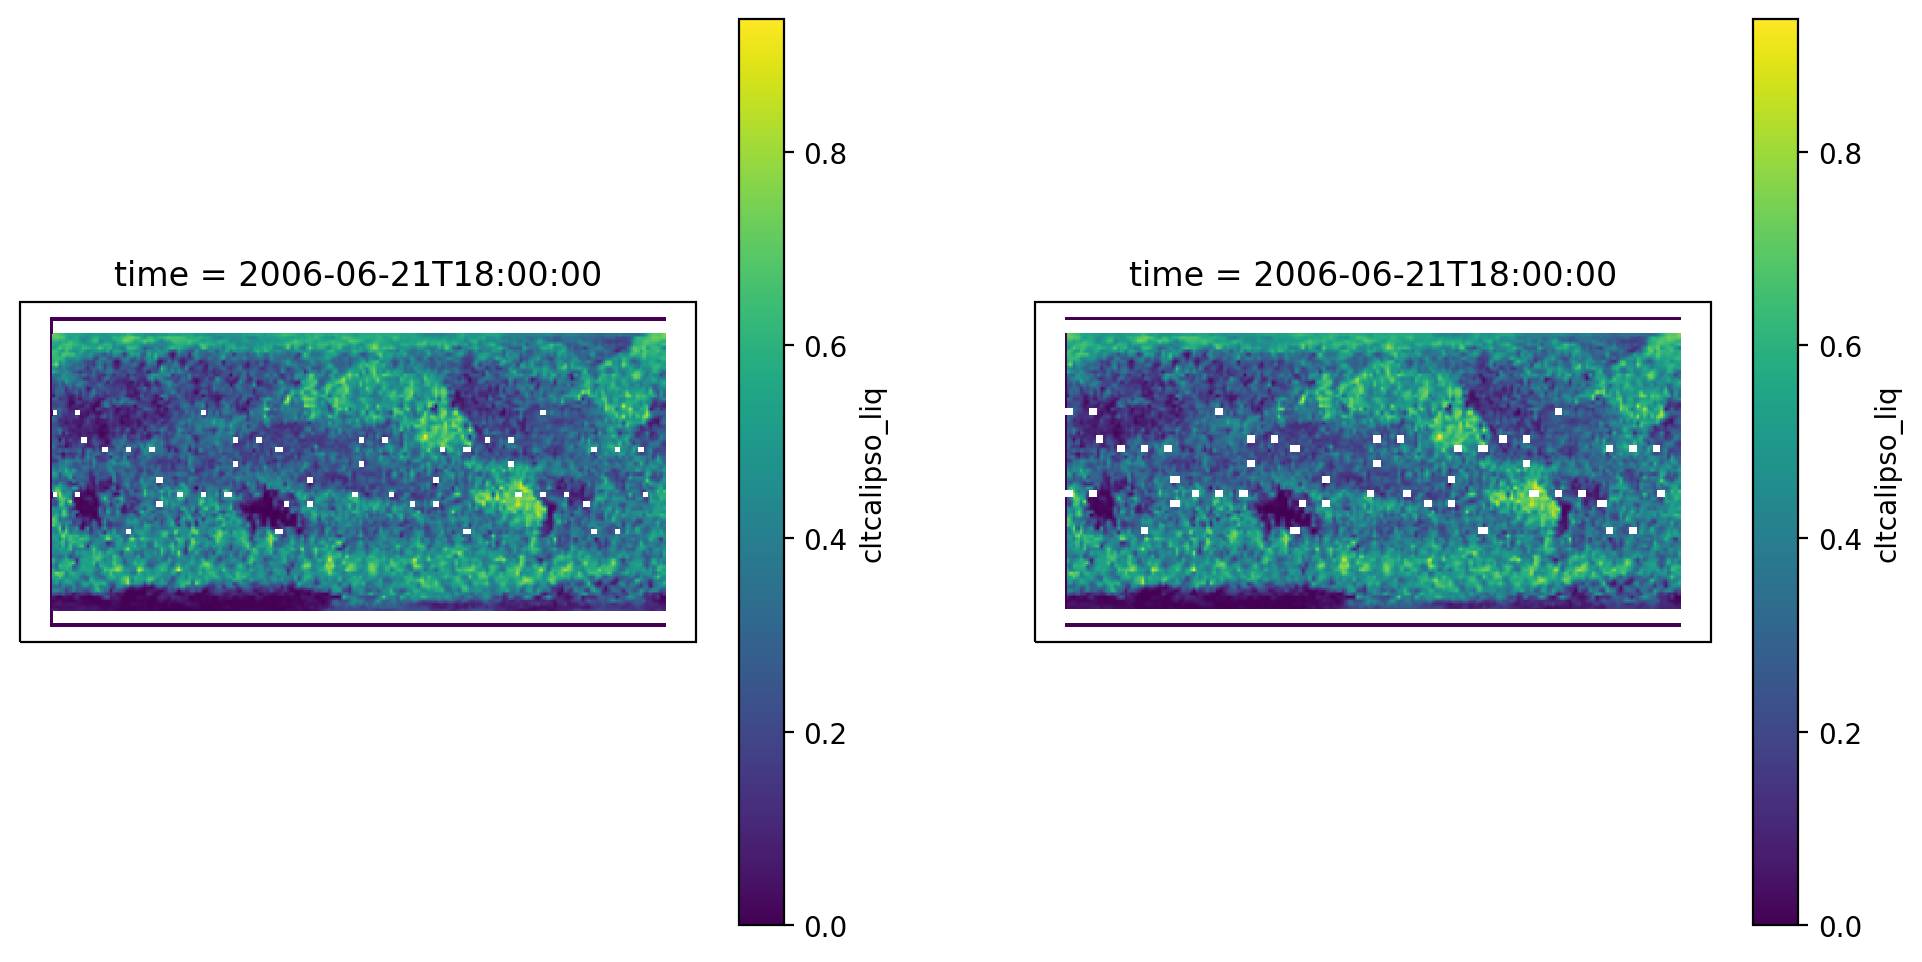

In [12]:
fig = plt.figure(figsize=[12,6],dpi=200)

ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=0))
ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=0))

raw_goccp['cltcalipso_liq'].plot(ax=ax1)
outtest['cltcalipso_liq'].plot(ax=ax2)

ax1.coastlines();
ax2.coastlines();

plt.show()

## Interpolate a directory of GOCCP files

In [13]:
%cd /glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata/
%ls

/glade/work/jonahshaw/obs/CALIPSO/GOCCP/2Ddata
1.25x0.9_from_1x1_python/  1.25x0.9_python_interp/  grid_2x2_L40/
1.25x0.9_interpolation/    grid_1x1xL40/            remapweights.nc


Open raw GOCCP data and 1x1 CESM grid (all variables monthly output).

## Test on a file subset

Select files, create outfile paths and make sure that those paths exist.

In [15]:
output_dir = '1.25x0.9_python_interp'
input_dir = '/grid_2x2_L40/2006/'

# Specify file to interpolate to.
target_file = '%s/cesm21/cesm2p1_B1850_COSP2_PCWG/atm/hist/%s' % (model_dir,'cesm2p1_B1850_COSP2_PCWG.cam.h0.0003-05.nc')

path = os.getcwd()

prefix = path + input_dir
in_files = os.listdir(prefix)

in_files_full = [prefix + i for i in in_files]
out_files_full = [i.replace(input_dir,output_dir) for i in in_files_full]

# Make sure the directory structure exists before writing files in interp_like2D
for i in out_files_full:
    parent = Path(i).parent
    Path(parent).mkdir(parents=True, exist_ok=True)

interp_files(in_files_full,out_files_full,target_file)

In [129]:
%ls 1.25x0.9_python_interp/2006/

MapLowMidHigh330m_200606_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200607_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200608_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200609_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200610_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200611_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh330m_200612_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200606_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200607_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200608_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200609_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200610_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200611_avg_CFMIP2_sat_3.1.2.nc
MapLowMidHigh_Phase330m_200612_avg_CFMIP2_sat_3.1.2.nc
